<h3>Objective:</h3>Use machine learning to detect fraud transactions

In [238]:
#load modules
import pandas as pd
import numpy as np
import calendar
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,recall_score,f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline


In [251]:
#load the dataset
training_data = pd.read_csv("./data/training.csv")
test_data = pd.read_csv("./data/test.csv")

<strong>Data Exploration</strong>
<p>Examine the data types and see if there are any missing values</p>

In [2]:
#check the data  types & any missing values
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB


In [3]:
#explore the data:take a look at the top data
training_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [55]:
#How many unique accounts,transactions, customers,batches & subscriptions
accounts = training_data.AccountId.nunique()
customers = training_data.CustomerId.nunique()
subscriptions =training_data.SubscriptionId.nunique() 
transactions  = training_data.TransactionId.nunique()
batches = training_data.BatchId.nunique()
print("accounts:",accounts,"customers:",customers,"subscriptions:",subscriptions,"transactions:",transactions,"batches:",batches)


accounts: 3633 customers: 3742 subscriptions: 3627 transactions: 95662 batches: 94809


<strong>Data Transformation</strong>
<p>Do a bit of feature engineering using the transaction time. 
Transform these dates into year, month, day & day of the week</p>

In [4]:
#Take a snapshot of the data so we know it's structure
training_data['TransactionStartTime'][:10]

0    2018-11-15T02:18:49Z
1    2018-11-15T02:19:08Z
2    2018-11-15T02:44:21Z
3    2018-11-15T03:32:55Z
4    2018-11-15T03:34:21Z
5    2018-11-15T03:35:10Z
6    2018-11-15T03:44:31Z
7    2018-11-15T03:45:13Z
8    2018-11-15T04:14:59Z
9    2018-11-15T04:31:48Z
Name: TransactionStartTime, dtype: object

In [276]:
#Define a function to extract year, month,day & hour from date column
def extract_date(data,column):
    '''The function take a dataframe and a column string arguments'''
    data["TransactionYear"]= data[column].apply(lambda x: x.year)
    data["TransactionMonth"]= data[column].apply(lambda x: x.month_name())
    data["TransactionDay"]= data[column].apply(lambda x: x.day_name())
    data["TransactionDayNum"]= data[column].apply(lambda x: x.dayofweek)
    data["TransactionHour"]= data[column].apply(lambda x: x.time().hour)
    
    
#add date & Month to the data
#convert TransactionStartTime to data
training_data['TransactionStartTime'] = pd.to_datetime(training_data['TransactionStartTime'])
extract_date(training_data,'TransactionStartTime')


#classify day of transaction as either weekend or weekday
training_data['DayofWeek']= np.where(training_data['TransactionDayNum']>5,'Weekend','Weekday')

#classify the time of day into morning,afternoon,evening(/night)
time_conditions=[(training_data['TransactionHour'])>18,
                (training_data['TransactionHour'])>12,
                (training_data['TransactionHour'])>5]
time_choices=['Night','Afternoon','Morning']

#split the time of transaction
training_data['TimeofDay']= np.select(time_conditions,time_choices,default='Night')
    

In [134]:
#subset the resulting dataframe
training_data[:10]

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,TransactionStartTime,PricingStrategy,FraudResult,TransactionYear,TransactionMonth,TransactionDay,TransactionDayNum,TransactionHour,DayofWeek,TimeofDay
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,2018-11-15 02:18:49,2,0,2018,November,Thursday,3,2,Weekday,Night
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2018-11-15 02:19:08,2,0,2018,November,Thursday,3,2,Weekday,Night
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,2018-11-15 02:44:21,2,0,2018,November,Thursday,3,2,Weekday,Night
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,2018-11-15 03:32:55,2,0,2018,November,Thursday,3,3,Weekday,Night
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2018-11-15 03:34:21,2,0,2018,November,Thursday,3,3,Weekday,Night
5,TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256,ProviderId_6,ProductId_3,airtime,...,2018-11-15 03:35:10,2,0,2018,November,Thursday,3,3,Weekday,Night
6,TransactionId_118063,BatchId_118460,AccountId_2442,SubscriptionId_1980,CustomerId_2858,UGX,256,ProviderId_5,ProductId_3,airtime,...,2018-11-15 03:44:31,4,0,2018,November,Thursday,3,3,Weekday,Night
7,TransactionId_100640,BatchId_38561,AccountId_4841,SubscriptionId_3829,CustomerId_2858,UGX,256,ProviderId_4,ProductId_6,financial_services,...,2018-11-15 03:45:13,2,0,2018,November,Thursday,3,3,Weekday,Night
8,TransactionId_51905,BatchId_93774,AccountId_272,SubscriptionId_4731,CustomerId_598,UGX,256,ProviderId_6,ProductId_10,airtime,...,2018-11-15 04:14:59,2,0,2018,November,Thursday,3,4,Weekday,Night
9,TransactionId_130161,BatchId_82409,AccountId_710,SubscriptionId_920,CustomerId_1053,UGX,256,ProviderId_1,ProductId_15,financial_services,...,2018-11-15 04:31:48,2,0,2018,November,Thursday,3,4,Weekday,Night


<strong>Exploratory Data Analysis</strong>
<p>We have a few fraudulent cases in the data.</p>

In [232]:
#How many fraudulent cases are in the dataset?
training_data['FraudResult'].value_counts()
#(193/95469)*100 (0.20%)

0.20215986341115966

In [11]:
#Compare average value for each product category
#Average amounts spend in Transport services are higher
training_data.groupby('ProductCategory')['Value'].mean()

ProductCategory
airtime                 6049.799609
data_bundles            3714.011159
financial_services     12734.467570
movies                 10988.000000
other                    500.000000
ticket                 96696.759259
transport             170240.000000
tv                     18156.438624
utility_bill           20946.692188
Name: Value, dtype: float64

<strong>Data Visualization</strong>
<h6>1. Daily Transactions per Product Category</h6>
<p>Airtime and Finacial services are the most popular products with a highest number of transactions happening around 5pm</p>
<p>Fraudulent transactions also happened between noon & 9 PM</p>

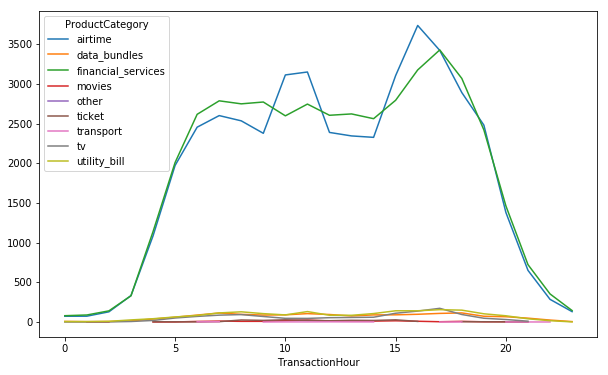

In [14]:
#Plot daily transactions
fig,ax = plt.subplots(figsize=(10,6))
#summaize transaction by time of day
#training_data.groupby(['TransactionHour','FraudResult']).count()['TransactionId'].unstack().plot.bar(ax=ax)
training_data.groupby(['TransactionHour','ProductCategory']).count()['TransactionId'].unstack().plot(ax=ax)

#plt.hist(training_data['TransactionDay']),
#plt.hist(training_data['TimeofDay'])

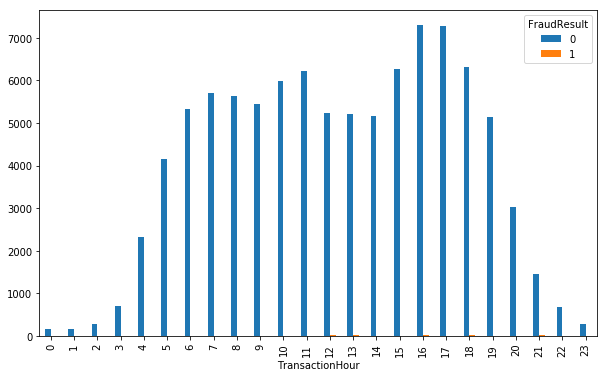

In [16]:
#check frequency of fraud transactions in a given hour
fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['TransactionHour','FraudResult']).count()['TransactionId'].unstack().plot.bar(ax=ax)

<h6>2. Fraud Transactions by Product Category</h6>
<p>Financial services had the highest number of fraudulent transactions followed by airtime.</>

In [17]:
#Fraud Result by product category
training_data.groupby(['ProductCategory','FraudResult']).count()['TransactionId']#.unstack().plot.bar(ax=ax)

ProductCategory     FraudResult
airtime             0              45009
                    1                 18
data_bundles        0               1613
financial_services  0              45244
                    1                161
movies              0                175
other               0                  2
ticket              0                216
transport           0                 23
                    1                  2
tv                  0               1279
utility_bill        0               1908
                    1                 12
Name: TransactionId, dtype: int64

<h6>3. Fraud Transactions by Value</h6>
<p>Transactions with the highest value were more likely to be fraudulent</p>

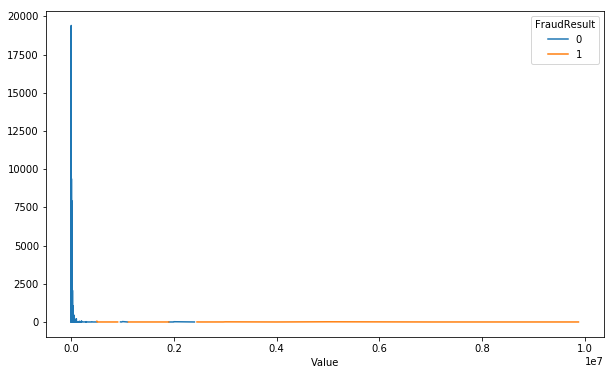

In [18]:
#compare fraud and transaction amount
fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['Value','FraudResult']).count()['TransactionId'].unstack().plot(ax=ax)

<h6> 4. Fraudulent Transactions by Provider ID</h6>
<p>Providers 3 & 5 had the highest number of fraudulent transactions</p>

In [19]:
#compare fraud results by provider 
#fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['ProviderId','FraudResult']).count()['TransactionId']#.unstack().plot(ax=ax)

ProviderId    FraudResult
ProviderId_1  0               5586
              1                 57
ProviderId_2  0                 18
ProviderId_3  0               3020
              1                 64
ProviderId_4  0              38184
              1                  5
ProviderId_5  0              14478
              1                 64
ProviderId_6  0              34183
              1                  3
Name: TransactionId, dtype: int64

<h6>5. Fraudulent Transaction by Product</h6>
<p>Product 15 had the highest number of fraudulent results</p>

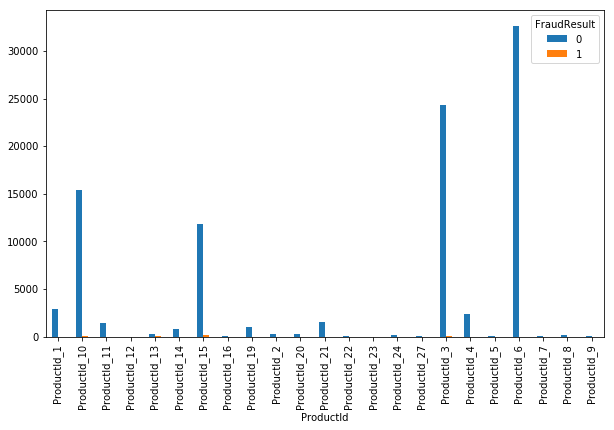

In [21]:
#compare fraud results by product type
#Product 15 has highest number of fraudulent transactions
fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['ProductId','FraudResult']).count()['TransactionId'].unstack().plot.bar(ax=ax)

<h6>6. Fradulent Transaction by Pricing Strategy</h6>
<p>Pricing Strategy 2 had the highest number of fraudulent transactions though Pricing Strategy 0 has highest % of fraudulent transactions (10%)</p>

In [22]:
#compare fraud results by pricing strategy
#fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['PricingStrategy','FraudResult']).count()['TransactionId']#.unstack().plot(ax=ax)

PricingStrategy  FraudResult
0                0                349
                 1                 36
1                0               1860
                 1                  7
2                0              79709
                 1                139
4                0              13551
                 1                 11
Name: TransactionId, dtype: int64

<h6>7. Fraudulent Transactions by Month</h6>
<p>January & December had the highest number of fraudulent transactions</p>
<p>Most of the Fraudulent Transactions occured in 2019. Also the majority of the fraudulent transactions happened on a weekday</p>

In [25]:
#compare fraud results by Month
#fig,ax = plt.subplots(figsize=(10,6))
training_data.groupby(['TransactionMonth','FraudResult']).count()['TransactionId']#.unstack().plot.bar(ax=ax)

TransactionMonth  FraudResult
December          0              35573
                  1                 62
February          0              15719
                  1                 53
January           0              31719
                  1                 64
November          0              12458
                  1                 14
Name: TransactionId, dtype: int64

In [26]:
#Fraud results per Year:
training_data.groupby(['TransactionYear','FraudResult']).count()['TransactionId']

TransactionYear  FraudResult
2018             0              48031
                 1                 76
2019             0              47438
                 1                117
Name: TransactionId, dtype: int64

In [28]:
#Fraud Results by day of the week
training_data.groupby(['DayofWeek','FraudResult']).count()['TransactionId']

DayofWeek  FraudResult
Weekday    0              85798
           1                178
Weekend    0               9671
           1                 15
Name: TransactionId, dtype: int64

In [129]:
#Which day of the week had highest fraud transactions?
training_data.groupby(['TransactionDay','FraudResult']).count()['ProviderId']

TransactionDay  FraudResult
Friday          0              27686
                1                 30
Monday          0              11808
                1                 29
Saturday        0              10078
                1                 25
Sunday          0               9671
                1                 15
Thursday        0              11005
                1                 34
Tuesday         0              15018
                1                 31
Wednesday       0              10203
                1                 29
Name: ProviderId, dtype: int64

<h6>8. Fraudulent Transactions by Channel Number</h6>
<p>Channel 3 had the highest fraudulent cases. Channel 1 had highest % of fraudulent transactions (0.75%.<br> Channel 5 didn't have any Fraudulent Transactions</p>

In [29]:
#Try subscription/customer,channels fraud instances
training_data.groupby(['ChannelId','FraudResult']).count()['TransactionId']

ChannelId    FraudResult
ChannelId_1  0                534
             1                  4
ChannelId_2  0              37136
             1                  5
ChannelId_3  0              56751
             1                184
ChannelId_5  0               1048
Name: TransactionId, dtype: int64

In [30]:
#transaction summary : quick stats on numerical data
training_data.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult,TransactionYear,TransactionDayNum,TransactionHour
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000,95662.000000,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018,2018.497115,3.011907,12.447722
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872,0.499994,1.863651,4.846964
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000,2018.000000,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000,2018.000000,1.000000,8.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000,2018.000000,3.000000,13.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000,2019.000000,4.000000,17.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000,2019.000000,6.000000,23.000000


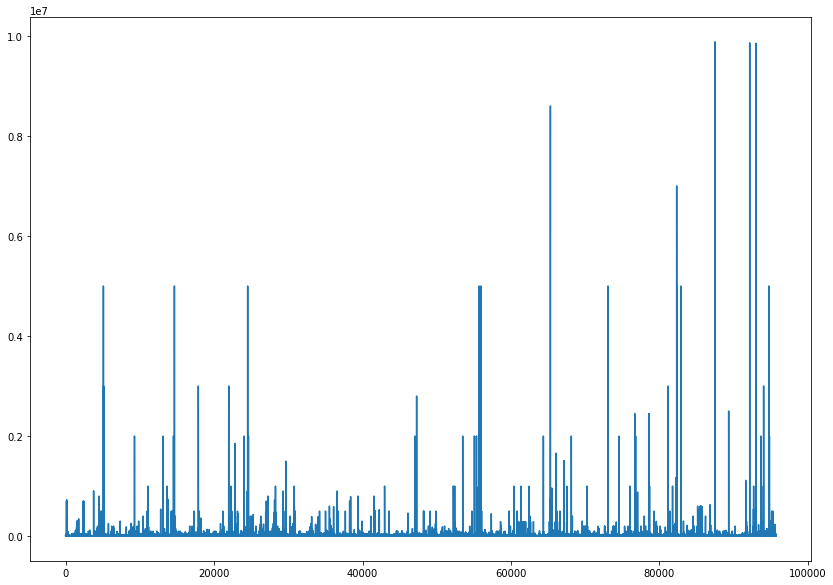

In [31]:
#plot the distribution of transaction Value
training_data['Value'].plot(figsize=(14,10))

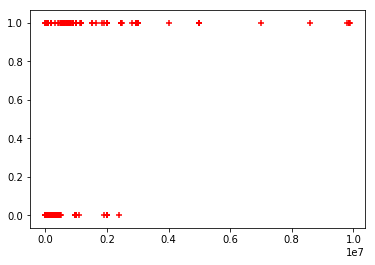

In [32]:
#plot the distribution of transaction Value &
#whether the transaction is fraudulent or not
plt.scatter(training_data.Value,training_data.FraudResult,marker="+",color="red")

From plot above, we can see that there is no clear distiction between fraudulent & non-fraudulent transactions
for amounts that are less than 400,000. Higher transaction Values are more likely to be fraudulent.

<h5>Data Modeling</h5>
<h6>Prepare the data for model prediction</h6>
<p>Here we create dummy data for modeling</p>

In [308]:
#Drop some columns
training_data_new = training_data.drop(
    ['TransactionId','BatchId','ChannelId',
     'AccountId','SubscriptionId',
     'CustomerId','CurrencyCode',
     'DayofWeek','ProductCategory',
     'CountryCode','TransactionDayNum',
     'Amount','TransactionStartTime'],axis=1)


In [309]:
training_data_new.head()

,ProviderId,ProductId,Value,PricingStrategy,FraudResult,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,TimeofDay
0,ProviderId_6,ProductId_10,1000,2,0,2018,November,Thursday,2,Night
1,ProviderId_4,ProductId_6,20,2,0,2018,November,Thursday,2,Night
2,ProviderId_6,ProductId_1,500,2,0,2018,November,Thursday,2,Night
3,ProviderId_1,ProductId_21,21800,2,0,2018,November,Thursday,3,Night
4,ProviderId_4,ProductId_6,644,2,0,2018,November,Thursday,3,Night


In [310]:
#Create dummy data for logistic modelling
#convert Pricing Strategy & Transaction Year into string
training_data_new[['PricingStrategy','TransactionYear']]=training_data_new[['PricingStrategy','TransactionYear']].astype(str)

cat_vars = training_data_new[['ProviderId','PricingStrategy',
                              'TransactionYear',
                              'TransactionMonth',
                              'ProductId',
                              'TransactionDay','TimeofDay']]
cat_list = pd.get_dummies(cat_vars, drop_first=True)

training_data_final = training_data_new.join(cat_list)
data_vars = training_data_final.columns.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

y = np.ravel(training_data_final[['FraudResult']])
X = training_data_final[[i for i in to_keep if i not in y]]
#X = X.iloc[:,6:-1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [311]:
X.head()

,Value,FraudResult,TransactionHour,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6,PricingStrategy_1,PricingStrategy_2,...,ProductId_ProductId_8,ProductId_ProductId_9,TransactionDay_Monday,TransactionDay_Saturday,TransactionDay_Sunday,TransactionDay_Thursday,TransactionDay_Tuesday,TransactionDay_Wednesday,TimeofDay_Morning,TimeofDay_Night
0,1000,0,2,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
1,20,0,2,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,500,0,2,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
3,21800,0,3,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,644,0,3,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [312]:
#Over sample the data in order to have balanced data
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['FraudResult'])

# Check the numbers in the dataset
print("length of oversampled data is ",len(os_data_X))
print("Number of no FraudResult in oversampled data",len(os_data_y[os_data_y['FraudResult']==0]))
print("Number of FraudResult",len(os_data_y[os_data_y['FraudResult']==1]))
print("Proportion of no FraudResult data in oversampled data is ",len(os_data_y[os_data_y['FraudResult']==0])/len(os_data_X))
print("Proportion of FraudResult data in oversampled data is ",len(os_data_y[os_data_y['FraudResult']==1])/len(os_data_X))

length of oversampled data is  133638
Number of no FraudResult in oversampled data 66819
Number of FraudResult 66819
Proportion of no FraudResult data in oversampled data is  0.5
Proportion of FraudResult data in oversampled data is  0.5


Recursive Feature Elimination (RFE)

In [313]:
#select features recursively
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 55)
rfe = rfe.fit(os_data_X,os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


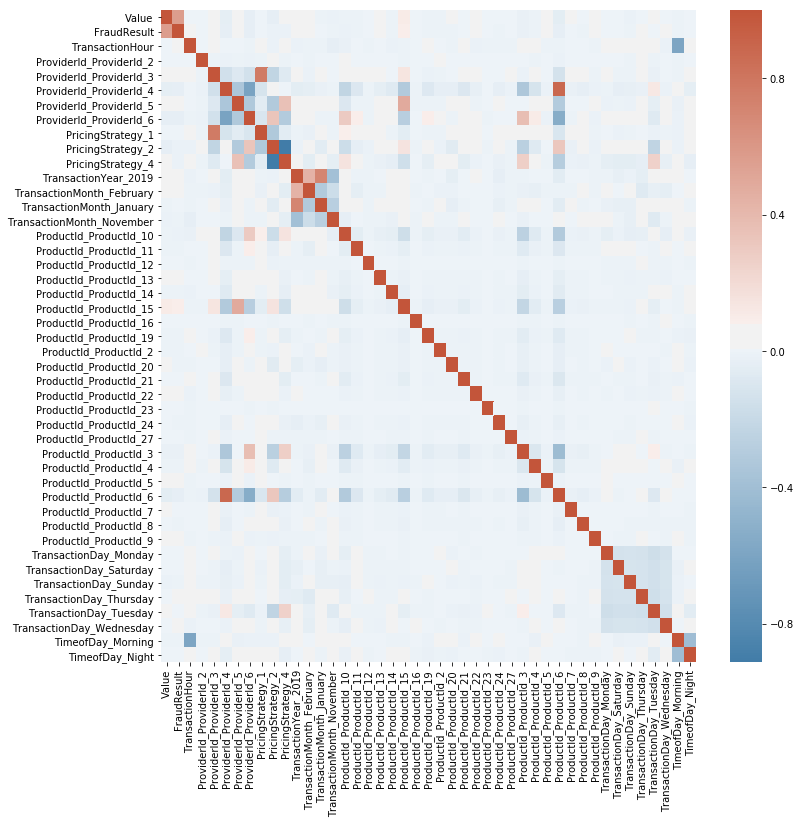

In [314]:
#check correlation between features
corr_data = training_data_final
corr=corr_data.corr()
fig, ax = plt.subplots(figsize=(12, 12))
colormap = sns.diverging_palette(240, 20, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=False, fmt=".2f")

#check top correlation pairs
#corr1=corr.abs().unstack().sort_values(ascending=False)
#corr1[0:50]

In [315]:
#update X, Y based on this result
X = os_data_X
y = os_data_y['FraudResult']

In [324]:
os_data_X.head()

,Value,FraudResult,TransactionHour,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6,PricingStrategy_1,PricingStrategy_2,...,ProductId_ProductId_8,ProductId_ProductId_9,TransactionDay_Monday,TransactionDay_Saturday,TransactionDay_Sunday,TransactionDay_Thursday,TransactionDay_Tuesday,TransactionDay_Wednesday,TimeofDay_Morning,TimeofDay_Night
0,3500,0,15,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1000,0,13,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1000,0,15,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,50,0,17,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,150,0,12,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0


In [323]:
#Model implementation
logit_model = sm.Logit(y,X)
result = logit_model.fit(method='bfgs')
print(result.summary2())

/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4
                                    Results: Logit
Model:                      Logit                  Pseudo R-squared:       0.000      
Dependent Variable:         FraudResult            AIC:                    185349.6058
Date:                       2019-07-29 01:32       BIC:                    185780.9330
No. Observations:           133638                 Log-Likelihood:         -92631.    
Df Model:                   43                     LL-Null:                -92631.    
Df Residuals:               133594                 LLR p-value:            1.0000     
Converged:                  0.0000                 Scale:                  1.0000     
--------------------------------------------------------------------------------------
                          Coef.    Std.Err.     z    P>|z|      [0.025       0.975]   
----------------------------------

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [322]:
#check features that might cause errors
logit_model.loglikeobs(result.params)

array([-0.69314718, -0.69314718, -0.69314718, ..., -0.69314718,
       -0.69314718, -0.69314718])

In [85]:
#split the training data into train & test data (80:20 split used)
#Get a dataframe of the features to use
#Amount = pd.DataFrame(training_data.Amount)
#FraudResult = pd.DataFrame(training_data.FraudResult)

#X_train to train the model & X_test to test the model
#X_train,X_test,y_train,y_test=train_test_split(Amount,FraudResult,test_size=0.2,random_state=42)


In [210]:
os_data_X.columns

Index(['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'TransactionYear',
       'TransactionDayNum', 'TransactionHour', 'ProviderId_ProviderId_2',
       'ProviderId_ProviderId_3', 'ProviderId_ProviderId_4',
       'ProviderId_ProviderId_5', 'ProviderId_ProviderId_6',
       'ProductId_ProductId_10', 'ProductId_ProductId_11',
       'ProductId_ProductId_12', 'ProductId_ProductId_13',
       'ProductId_ProductId_14', 'ProductId_ProductId_15',
       'ProductId_ProductId_16', 'ProductId_ProductId_19',
       'ProductId_ProductId_2', 'ProductId_ProductId_20',
       'ProductId_ProductId_21', 'ProductId_ProductId_22',
       'ProductId_ProductId_23', 'ProductId_ProductId_24',
       'ProductId_ProductId_27', 'ProductId_ProductId_3',
       'ProductId_ProductId_4', 'ProductId_ProductId_5',
       'ProductId_ProductId_6', 'ProductId_ProductId_7',
       'ProductId_ProductId_8', 'ProductId_ProductId_9',
       'ProductCategory_data_bundles', 'ProductCategory_financial_services',
       

In [222]:
#create object class of the model
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
logmodel = LogisticRegression(solver="lbfgs")
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [227]:
#Make predictions using the model
y_pred = logmodel.predict(X_test)
print("Accuracy of the logistic classifier is: {:.4f}".format(logmodel.score(X_test,y_test)))

Accuracy of the logistic classifier is: 0.9728


In [250]:
#use confusion matrix (97% accuacy)
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
#(19692+19309)/(19692+19309+320+771)

[[19692   320]
 [  771 19309]]


In [230]:
#precision recall
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     20012
           1       0.98      0.96      0.97     20080

    accuracy                           0.97     40092
   macro avg       0.97      0.97      0.97     40092
weighted avg       0.97      0.97      0.97     40092



In [236]:
#test using randomforest classifier
#Train model
rf_model = RandomForestClassifier(n_estimators=10).fit(X_train,y_train)

#make predictions
rf_pred = rf_model.predict(X_test)

array([1, 0, 1, ..., 0, 1, 1])

In [252]:
#Accuracy score
#accuracy = accuracy_score(y_test,rf_pred)
#f1_score = f1_score(y_test,rf_pred)
#recall_score1 = recall_score(y_test,rf_pred)
#print("Accuracy: {:.4f}",accuracy,"F1 Score: {:.4f}",f1_score,"Recall: {:.4f}",recall_score)
#print("Accuracy: ",accuracy,"Recall: {:.4f}",recall_score)

In [273]:
#prepare the test data for prediction
test_data1 = test_data
test_data1.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [ ]:
#convert TransactionStartTime to data
test_data1['TransactionStartTime'] = pd.to_datetime(test_data1['TransactionStartTime'])
extract_date(test_data1,'TransactionStartTime')

#classify day of transaction as either weekend or weekday
test_data1['DayofWeek']= np.where(test_data1['TransactionDayNum']>5,'Weekend','Weekday')

#classify the time of day into morning,afternoon,evening(/night)
time_conditions=[(test_data1['TransactionHour'])>18,
                (test_data1['TransactionHour'])>12,
                (test_data1['TransactionHour'])>5]
time_choices=['Night','Afternoon','Morning']

#split the time of transaction
test_data1['TimeofDay']= np.select(time_conditions,time_choices,default='Night')
